In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 2.5 MB/s eta 0:00:00


In [2]:
#X_train = pd.read_csv('X_train_wFeatures-clean.csv', index_col=0)

y_train = pd.read_csv('y_train_wFeatures-clean.csv', index_col=0)[::5]
X_val = pd.read_csv('X_val_wFeatures-clean.csv', index_col=0)[::5]
y_val = pd.read_csv('y_val_wFeatures-clean.csv', index_col=0)[::5]
X_test = pd.read_csv('X_test_wFeatures-clean.csv', index_col=0)
y_test = pd.read_csv('y_test_wFeatures-clean.csv', index_col=0)

In [3]:
import optuna

In [4]:
work_features = [c for c in X_val.columns if not c.startswith('Cluster_number')]

#X_train = X_train[work_features]
X_val = X_val[work_features]
X_test = X_test[work_features]

y_train = y_train.values.argmax(1)
y_val = y_val.values.argmax(1)
y_test = y_test.values.argmax(1)

In [ ]:

#multilabel_classifier = MultiOutputClassifier(SVC()).fit(X_val,y_val)
from sklearn.svm import SVC
svm_model = SVC(kernel='linear',C=0.01).fit(X_val,y_val)
preds = svm_model.predict(X_test)
print(f1_score(y_test, preds, average='weighted'))

0.4192135349811419


In [ ]:
def objective(trial):
    params={}
    params['C'] = trial.suggest_loguniform('C', 0.1, 30)
    params['gamma'] = trial.suggest_loguniform('gamma', 0.0001, 1)
    params['kernel'] = trial.suggest_categorical('kernel', ["linear", "poly", "rbf", "sigmoid"])
    params['degree'] = trial.suggest_int('degree', 1, 5)
    params['coef0'] = trial.suggest_float("coef0", -1, 1)
    model = SVC(**params)
    res = cross_val_score(model, X_val, y_val, scoring='f1_weighted',cv=5).mean()
    return res

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

trial = study.best_trial
print('Best score: {}'.format(trial.value))


[I 2023-01-18 17:29:38,773] A new study created in memory with name: no-name-dc7cea60-7158-4923-9acf-fd8588a03e4d
<ipython-input-5-dfcd1e99290a>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  params['C'] = trial.suggest_loguniform('C', 0.1, 30)
<ipython-input-5-dfcd1e99290a>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  params['gamma'] = trial.suggest_loguniform('gamma', 0.0001, 1)
[I 2023-01-18 17:48:17,253] Trial 0 finished with value: 0.43705306136862204 and parameters: {'C': 3.2631756803577696, 'gamma': 0.01987677136147995, 'kernel': 'linear', 'degree': 3, 'coef0': -0.15195369686061833}. Best is trial 0 with value: 0.43705306136862204.

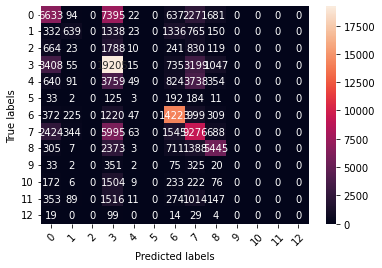

In [ ]:
from sklearn.metrics import confusion_matrix
m = sklearn.metrics.confusion_matrix(y_test, preds)
ax = sns.heatmap(m, annot=True, fmt='d')
ax.set(xlabel="Predicted labels", ylabel="True labels",)
       #xticklabels=label_categories, yticklabels=label_categories)

plt.yticks(rotation=0)
plt.xticks(rotation=45)

plt.show()